# Load Training Data

In [1]:
%load_ext autoreload
%autoreload 2
# https://pykoopman.readthedocs.io/en/master/tutorial_koopman_edmdc_for_vdp_system.html

In [56]:
from robot_tools.trajer import TrajTools, recorder, TrajsPainter, TrajInfo

data = recorder.json_process("trajs_recorder_0211_17.json")

(obs_trajs, raw_state_info) = TrajTools.construct_trajs(
    data, "observation", series_type="h", mixed_type="h", show_info=True
)

(act_trajs, raw_act_info) = TrajTools.construct_trajs(
    data, "action", series_type="h", mixed_type="h", show_info=True
)

# ? 为什么突然要指明类型了？
raw_state_info:TrajInfo
raw_act_info:TrajInfo

# Training data
RAW_STATE_MIXED = obs_trajs[2][:2,:]
RAW_ACTION_MIXED = act_trajs[2]
RAW_STATE_SERIES = obs_trajs[1][:2,:]
RAW_ACTION_SERIES = act_trajs[1]
assert RAW_STATE_MIXED.shape == RAW_ACTION_MIXED.shape
assert RAW_ACTION_SERIES.shape == RAW_STATE_SERIES.shape

observation trajectories number:  1
observation each points number:  [1000.]
observation points dim:  3
action trajectories number:  1
action each points number:  [1000.]
action points dim:  2


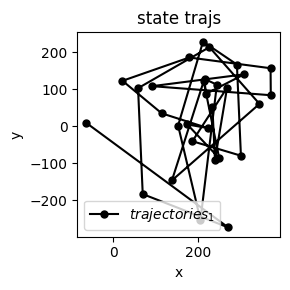

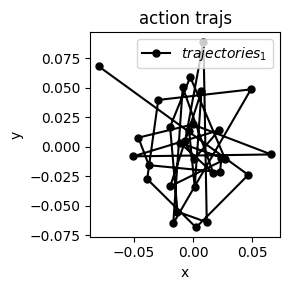

[[ -62.4921875   270.0369873    69.5          58.5       ]
 [   8.22503662 -274.21795654 -184.          102.5       ]]
[[-0.07953719  0.04676094  0.00263141 -0.03870455]
 [ 0.06794114 -0.02397263 -0.06852562 -0.02747946]]


In [57]:
# draw 2D raw data
show_points_num = 30
raw_state_painter = TrajsPainter(RAW_STATE_MIXED, raw_state_info)
raw_state_painter.figure_size_2D = (3, 3)
raw_state_painter.features_axis_labels = ["x", "y", "yaw"]
raw_state_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), title="state trajs")
raw_act_painter = TrajsPainter(RAW_ACTION_MIXED, raw_act_info)
raw_act_painter.figure_size_2D = (3, 3)
raw_act_painter.features_axis_labels = ["x", "y", "yaw"]
raw_act_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), title="action trajs")

print(RAW_STATE_SERIES[:, 0:4])
print(RAW_ACTION_SERIES[:, 0:4])
# print(RAW_STATE_MIXED[:, 0:4])
# print(RAW_ACTION_MIXED[:, 0:4])

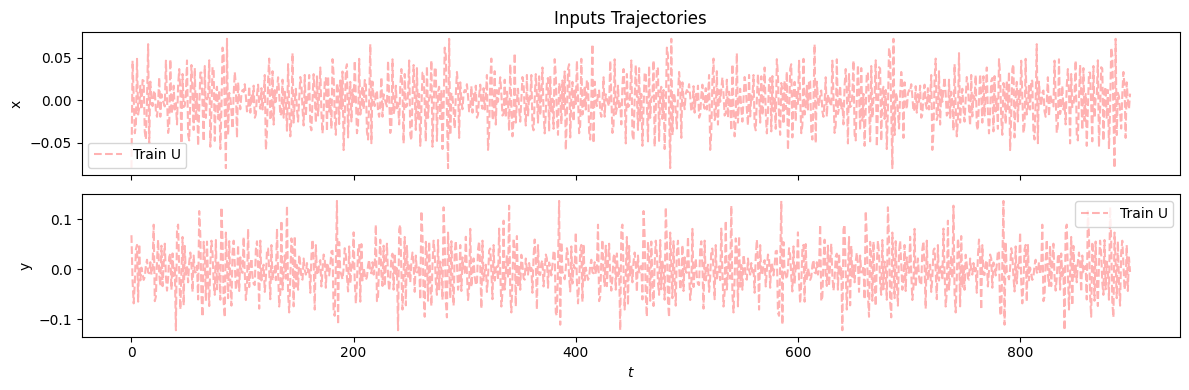

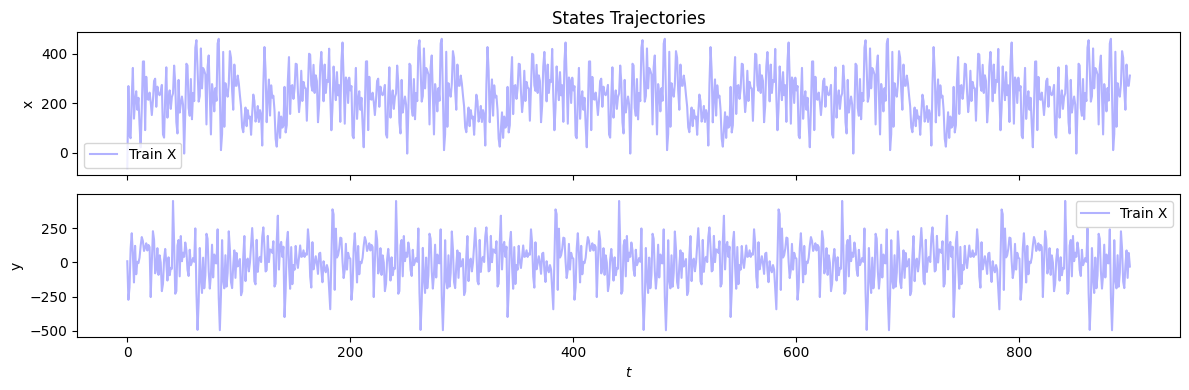

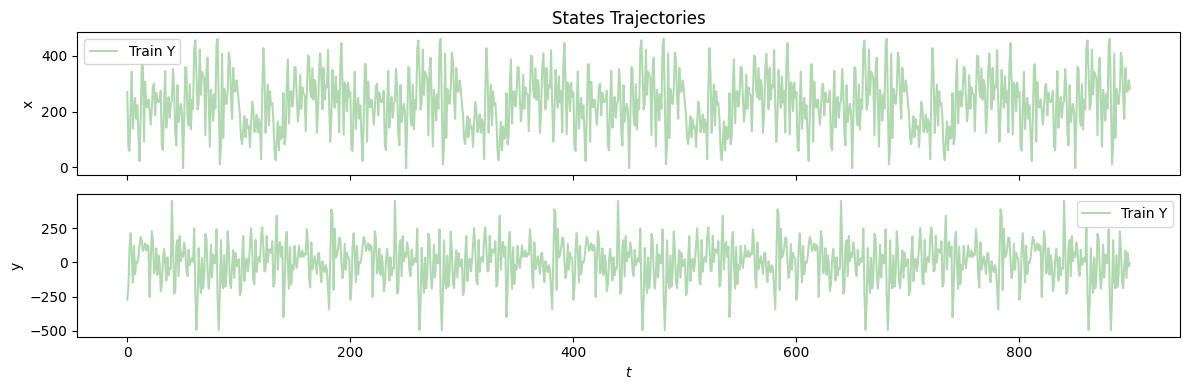

In [58]:
# draw 1D X Y U data
points_num = 900
start_point = 0
end_point = int(start_point + points_num)
trajs = (0,)
assert end_point <= raw_state_info.each_points_num[0]
raw_state_info.points_dim = 2
raw_act_info.points_dim = 2

X, X_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES, raw_state_info, (start_point, end_point), trajs
)
Y, Y_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES,
    raw_state_info,
    (start_point + 1, end_point + 1),
    trajs,
)
U, U_info = TrajTools.get_sub_series_trajs(
    RAW_ACTION_SERIES,
    raw_act_info,
    (start_point, end_point),
    trajs,
)

u_painter = TrajsPainter(U, U_info)
u_painter.features_sharetitle = "Inputs Trajectories"
u_painter.features_self_labels = "Train U"
u_painter.features_lines = "--r"
u_painter.features_axis_labels = ["x", "y", "yaw"]
u_painter.plot_features_with_t((0, points_num), (0,), (0, 1))

x_painter = TrajsPainter(X, X_info)
x_painter.features_sharetitle = "States Trajectories"
x_painter.features_self_labels = "Train X"
x_painter.features_lines = "-b"
x_painter.features_axis_labels = ["x", "y", "yaw"]
x_painter.plot_features_with_t((0, points_num), (0,), (0, 1))

y_painter = TrajsPainter(Y, Y_info)
y_painter.features_sharetitle = "States Trajectories"
y_painter.features_self_labels = "Train Y"
y_painter.features_lines = "-g"
y_painter.features_axis_labels = ["x", "y", "yaw"]
y_painter.plot_features_with_t((0, points_num), (0,), (0, 1))

# Koopman using EDMDc

## Training

In [59]:
import pykoopman as pk
import warnings
import numpy as np
np.random.seed(42)  # for reproducibility
warnings.filterwarnings("ignore")
from pykoopman.regression import EDMDc
from pykoopman.observables import RadialBasisFunction, Polynomial

In [60]:
EDMDc_ = EDMDc()

"""径向基方法"""
# 收敛拟合
# rbf_type = "thinplate"  # 'thinplate' polyharmonic gauss invquad invmultquad
# regressor = RadialBasisFunction(
#     rbf_type=rbf_type,
#     n_centers=10,
#     centers=None,
#     kernel_width=1.0,
#     polyharmonic_coeff=2.0,
#     include_state=True,
# )
# 发散拟合
# EDMDc_ = EDMDc()
# centers = np.random.uniform(-1,1,(2,5))
# regressor = RadialBasisFunction(
#     rbf_type="thinplate",
#     n_centers=centers.shape[1],
#     centers=centers,
#     kernel_width=1,
#     polyharmonic_coeff=1,
#     include_state=True,
# )
# test
# rbf_type = "polyharmonic"  # 'thinplate' polyharmonic gauss invquad invmultquad
# regressor = RadialBasisFunction(
#     rbf_type=rbf_type,
#     n_centers=10,
#     centers=None,
#     kernel_width=1.0,
#     polyharmonic_coeff=2.0,
#     include_state=True,
# )
"""多项式方法"""
# 良好拟合
# regressor = Polynomial(degree=2)
# 错误拟合
regressor = Polynomial(degree=2, include_bias=True, interaction_only=True)

model = pk.Koopman(observables=regressor, regressor=EDMDc_)
model.fit(X.T, y=Y.T, u=U.T)

Koopman(observables=Polynomial(interaction_only=True), regressor=EDMDc())

In [38]:
print(model.A), print("")
print(model.B), print("")
print(model.C), print("")
print(model.W), print("")

[[ 1.00000000e+00 -6.19509598e-12 -1.86686240e-12  5.01781676e-15]
 [ 7.80802829e-01  9.96388558e-01  2.81501462e-02 -1.48124771e-04]
 [ 6.20701443e-01 -2.77178270e-03  9.97704415e-01  3.78339406e-05]
 [-5.53769487e+03  2.06066305e+01  2.83597351e+02 -2.11367640e-01]]

[[ 1.13820729e-08  7.00906514e-09]
 [-4.17446751e+03  1.54265852e+01]
 [-3.94366656e+01 -4.09594512e+03]
 [-8.44289585e+04 -1.01622606e+06]]

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]]

[[ 1.22731569e-04  1.87329556e-02  2.06326597e-03  2.48196510e-01]
 [-3.08516326e-05  2.88417785e-03 -4.44773693e-03  7.10559497e-03]]



(None, None)

In [61]:
# 在训练集上回归
# 这里因为只有一个轨迹，所以采用了简化的方式
Xtrain = X
x0 = X[:, 0]

print(x0.shape)
print(U.shape)

points_num = 90
Xkoop = model.simulate(x0, U.T[:points_num,:], n_steps=points_num - 1)
Xkoop = np.vstack([x0, Xkoop])  # add initial point
Xkoop = Xkoop.T

(2,)
(2, 900)


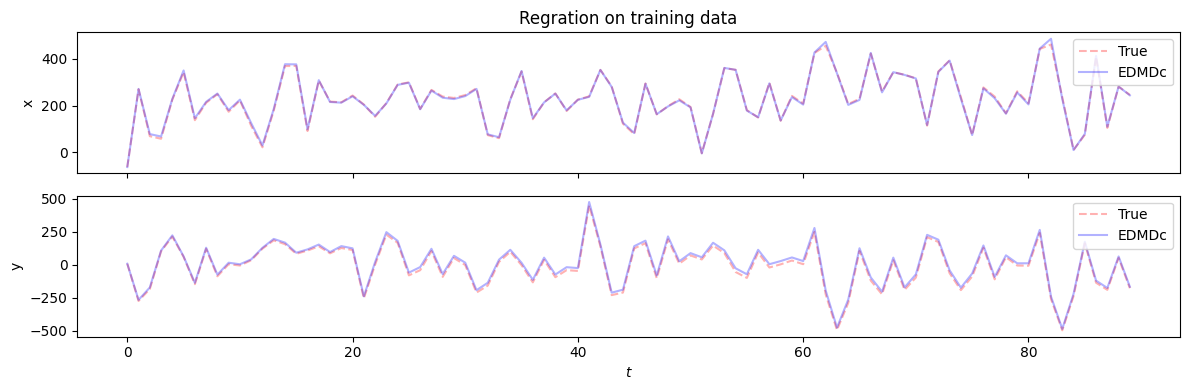

In [62]:
# 绘图
from robot_tools.trajer import TrajInfo

max_train_draw = 90
Xkoop_info = Xtrain_info = TrajInfo.consruct(
    Xtrain,
    "series_h",
    1,
)

trajs_painter = TrajsPainter()
trajs_painter.update_trajs(Xtrain, Xtrain_info)
trajs_painter.features_self_labels = "True"
trajs_painter.features_lines = "--r"
trajs_painter.features_sharetitle = "Regration on training data"
trajs_painter.features_axis_labels = ["x", "y", "yaw"]
axis = trajs_painter.plot_features_with_t(
    (0, max_train_draw), (0,), (0, 1), return_axis=True
)

trajs_painter.update_trajs(Xkoop, Xkoop_info)
trajs_painter.features_self_labels = "EDMDc"
trajs_painter.features_lines = "-b"
trajs_painter.plot_features_with_t((0, max_train_draw), (0,), (0, 1), given_axis=axis)

## Testing

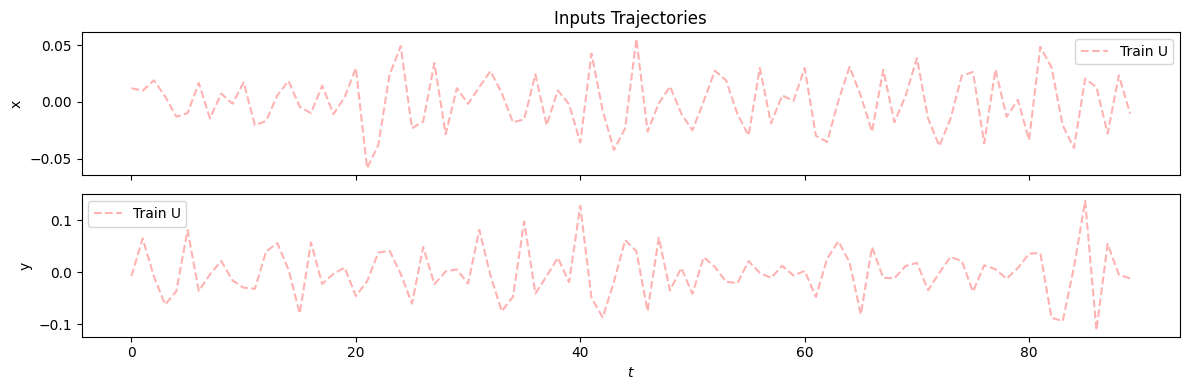

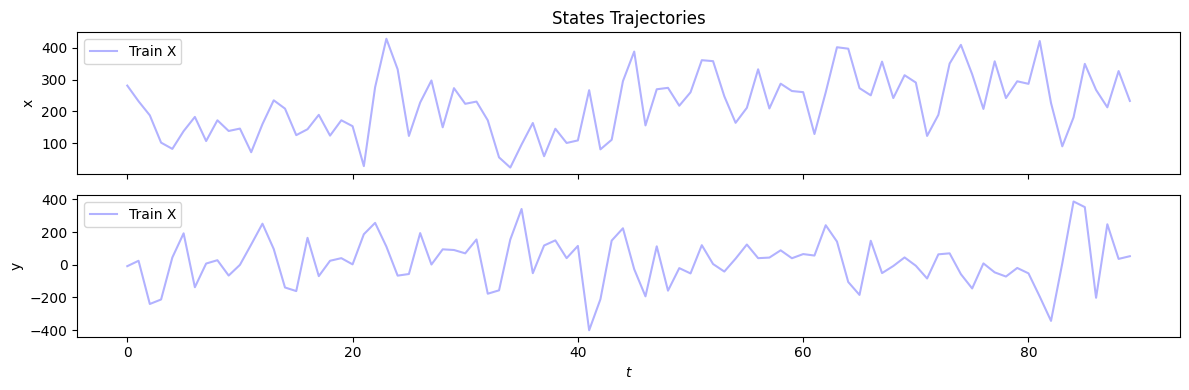

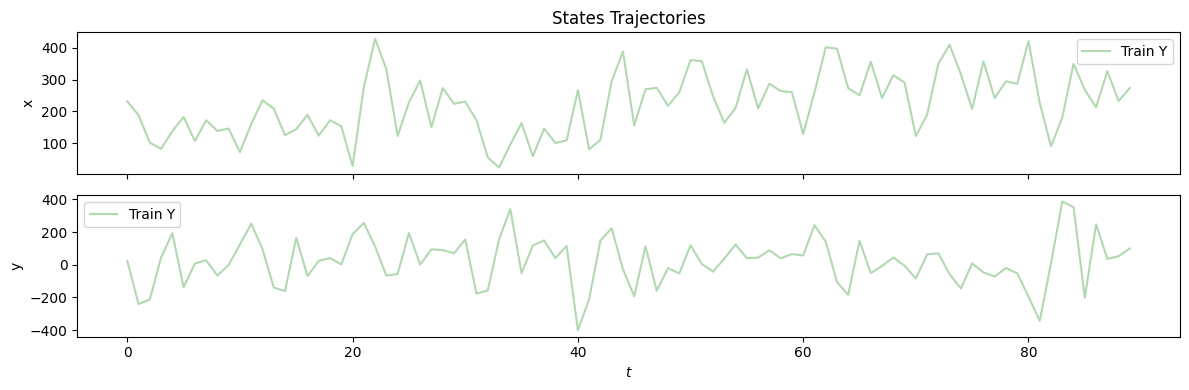

In [63]:
# draw 1D X Y U data
points_num = 90
start_point = 900
end_point = int(start_point + points_num)
trajs = (0,)
assert end_point <= raw_state_info.each_points_num[0]
raw_state_info.points_dim = 2
raw_act_info.points_dim = 2

X, X_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES, raw_state_info, (start_point, end_point), trajs
)
Y, Y_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES,
    raw_state_info,
    (start_point + 1, end_point + 1),
    trajs,
)
U, U_info = TrajTools.get_sub_series_trajs(
    RAW_ACTION_SERIES,
    raw_act_info,
    (start_point, end_point),
    trajs,
)

u_painter = TrajsPainter(U, U_info)
u_painter.features_sharetitle = "Inputs Trajectories"
u_painter.features_self_labels = "Train U"
u_painter.features_lines = "--r"
u_painter.features_axis_labels = ["x", "y", "yaw"]
u_painter.plot_features_with_t((0, points_num), (0,), (0, 1))

x_painter = TrajsPainter(X, X_info)
x_painter.features_sharetitle = "States Trajectories"
x_painter.features_self_labels = "Train X"
x_painter.features_lines = "-b"
x_painter.features_axis_labels = ["x", "y", "yaw"]
x_painter.plot_features_with_t((0, points_num), (0,), (0, 1))

y_painter = TrajsPainter(Y, Y_info)
y_painter.features_sharetitle = "States Trajectories"
y_painter.features_self_labels = "Train Y"
y_painter.features_lines = "-g"
y_painter.features_axis_labels = ["x", "y", "yaw"]
y_painter.plot_features_with_t((0, points_num), (0,), (0, 1))

In [64]:
# 在测试集上回归
# 这里因为只有一个轨迹，所以采用了简化的方式
Xtrain = X
x0 = X[:, 0]

print(x0.shape)
print(U.shape)

Xkoop = model.simulate(x0, U.T[:points_num,:], n_steps=points_num - 1)
Xkoop = np.vstack([x0, Xkoop])  # add initial point
Xkoop = Xkoop.T

(2,)
(2, 90)


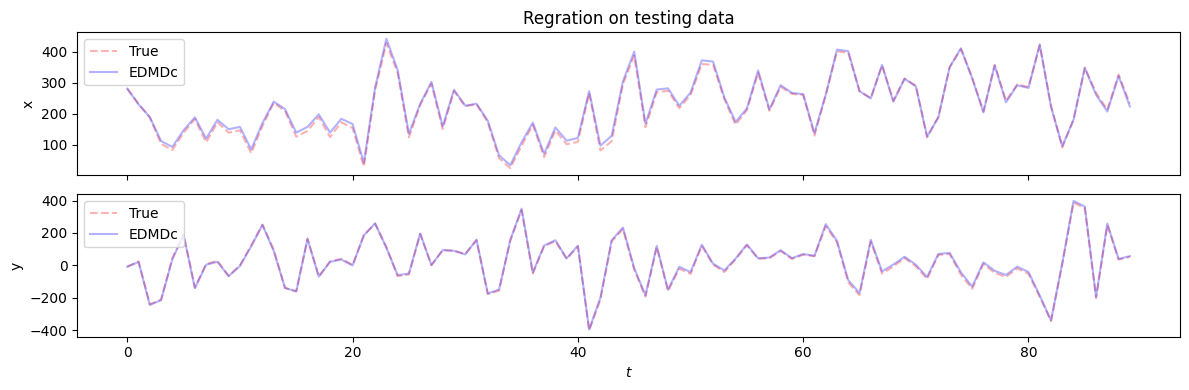

In [65]:
# 绘图
from robot_tools.trajer import TrajInfo

max_train_draw = 90
Xkoop_info = Xtrain_info = TrajInfo.consruct(
    Xtrain,
    "series_h",
    1,
)

trajs_painter = TrajsPainter()
trajs_painter.update_trajs(Xtrain, Xtrain_info)
trajs_painter.features_self_labels = "True"
trajs_painter.features_lines = "--r"
trajs_painter.features_sharetitle = "Regration on testing data"
trajs_painter.features_axis_labels = ["x", "y", "yaw"]
axis = trajs_painter.plot_features_with_t(
    (0, max_train_draw), (0,), (0, 1), return_axis=True
)

trajs_painter.update_trajs(Xkoop, Xkoop_info)
trajs_painter.features_self_labels = "EDMDc"
trajs_painter.features_lines = "-b"
trajs_painter.plot_features_with_t((0, max_train_draw), (0,), (0, 1), given_axis=axis)

In [66]:
err = np.linalg.norm(Xtrain - Xkoop)
print(f"Error: {err:.2f}")

Error: 103.79


# 最小二乘拟合对比

In [44]:
import numpy as np
from robot_tools.datar import least_squares
X_L = np.vstack([X, U])
print(X_L[:, 0:4])
print(X_L.shape)
print(Y.shape)
K = least_squares(X_L.T, Y.T)
print(K)

[[-6.24921875e+01  2.70036987e+02  6.95000000e+01  5.85000000e+01]
 [ 8.22503662e+00 -2.74217957e+02 -1.84000000e+02  1.02500000e+02]
 [-7.95371907e-02  4.67609397e-02  2.63140957e-03 -3.87045504e-02]
 [ 6.79411422e-02 -2.39726295e-02 -6.85256178e-02 -2.74794607e-02]]
(4, 900)
(2, 900)
[[ 9.99616553e-01 -8.96128811e-03 -4.18440567e+03  1.93339684e+01]
 [-3.57819324e-04  1.00745037e+00 -4.30480955e+01 -4.10035243e+03]]


In [45]:
# 在训练集上回归
# 这里因为只有一个轨迹，所以采用了简化的方式
Xtrain = X
x0 = X[:, 0]

print(x0.shape)
print(U[:, 0].shape)
print(U.shape)

def simulate(x0, U, K, n_steps):
    Xkoop = np.zeros((x0.shape[0], n_steps))
    x = x0
    for i in range(n_steps):
        x = np.dot(K, np.concatenate([x, U[:, i]]))
        Xkoop[:, i] = x
    return Xkoop.T

points_num = 90
Xkoop = simulate(x0, U, K, n_steps=points_num - 1)
Xkoop = np.vstack([x0, Xkoop])  # add initial point
Xkoop = Xkoop.T

(2,)
(2,)
(2, 900)


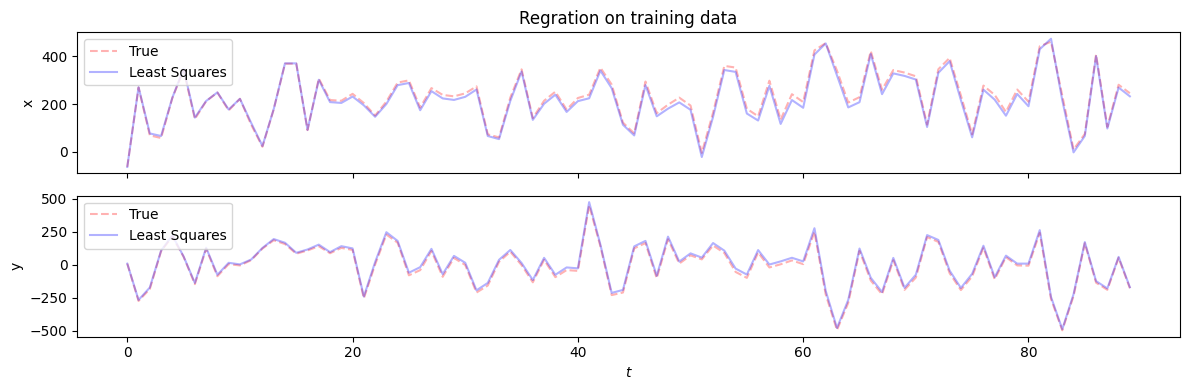

In [46]:
# 绘图
from robot_tools.trajer import TrajInfo

max_train_draw = 90
Xkoop_info = Xtrain_info = TrajInfo.consruct(
    Xtrain,
    "series_h",
    1,
)

trajs_painter = TrajsPainter()
trajs_painter.update_trajs(Xtrain, Xtrain_info)
trajs_painter.features_self_labels = "True"
trajs_painter.features_lines = "--r"
trajs_painter.features_sharetitle = "Regration on training data"
trajs_painter.features_axis_labels = ["x", "y", "yaw"]
axis = trajs_painter.plot_features_with_t(
    (0, max_train_draw), (0,), (0, 1), return_axis=True
)

trajs_painter.update_trajs(Xkoop, Xkoop_info)
trajs_painter.features_self_labels = "Least Squares"
trajs_painter.features_lines = "-b"
trajs_painter.plot_features_with_t((0, max_train_draw), (0,), (0, 1), given_axis=axis)

In [53]:
err = np.linalg.norm(Xtrain - Xkoop)
print(f"Error: {err:.2f}")

Error: 128.31


## Testing

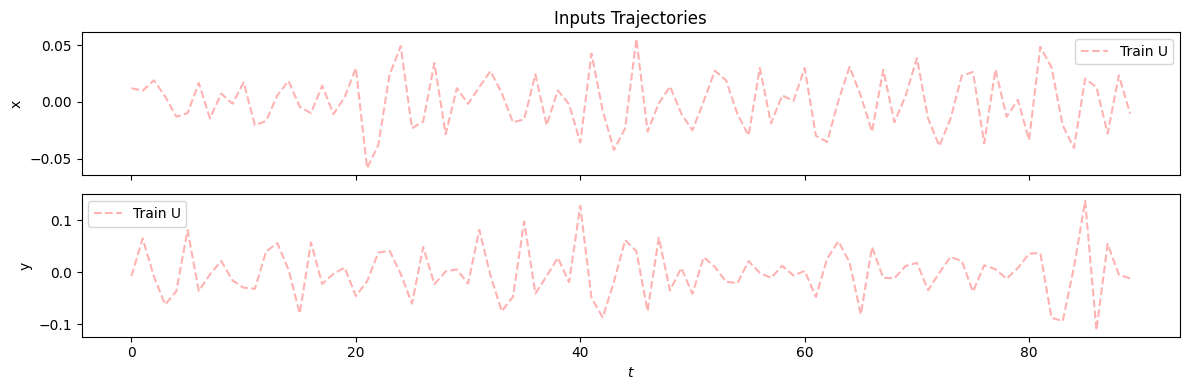

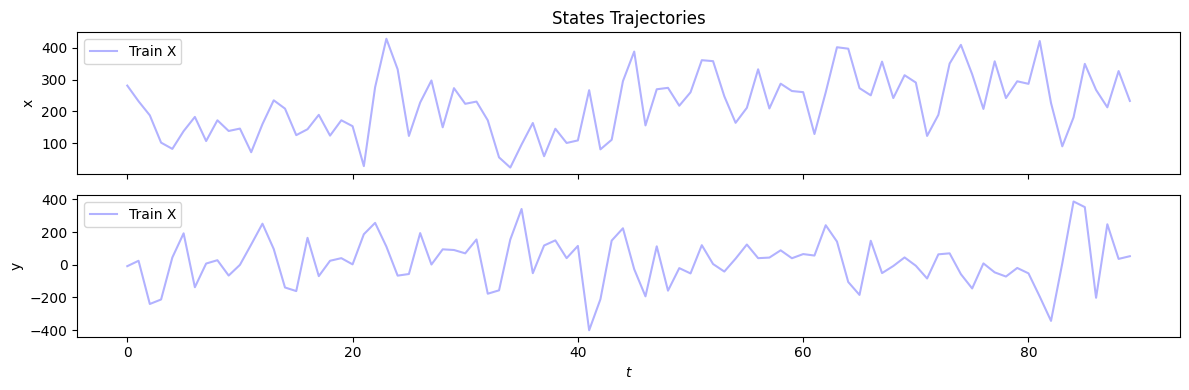

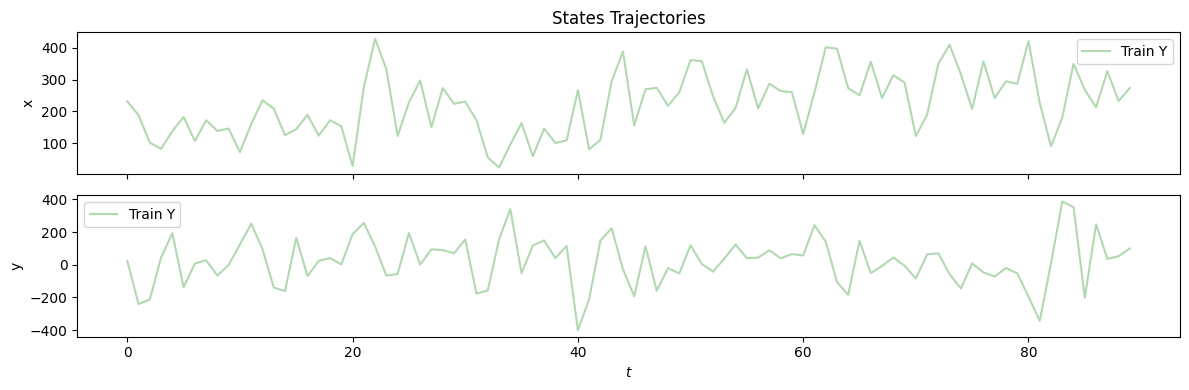

In [48]:
# draw 1D X Y U data
points_num = 90
start_point = 900
end_point = int(start_point + points_num)
trajs = (0,)
assert end_point <= raw_state_info.each_points_num[0]
raw_state_info.points_dim = 2
raw_act_info.points_dim = 2

X, X_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES, raw_state_info, (start_point, end_point), trajs
)
Y, Y_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES,
    raw_state_info,
    (start_point + 1, end_point + 1),
    trajs,
)
U, U_info = TrajTools.get_sub_series_trajs(
    RAW_ACTION_SERIES,
    raw_act_info,
    (start_point, end_point),
    trajs,
)

u_painter = TrajsPainter(U, U_info)
u_painter.features_sharetitle = "Inputs Trajectories"
u_painter.features_self_labels = "Train U"
u_painter.features_lines = "--r"
u_painter.features_axis_labels = ["x", "y", "yaw"]
u_painter.plot_features_with_t((0, points_num), (0,), (0, 1))

x_painter = TrajsPainter(X, X_info)
x_painter.features_sharetitle = "States Trajectories"
x_painter.features_self_labels = "Train X"
x_painter.features_lines = "-b"
x_painter.features_axis_labels = ["x", "y", "yaw"]
x_painter.plot_features_with_t((0, points_num), (0,), (0, 1))

y_painter = TrajsPainter(Y, Y_info)
y_painter.features_sharetitle = "States Trajectories"
y_painter.features_self_labels = "Train Y"
y_painter.features_lines = "-g"
y_painter.features_axis_labels = ["x", "y", "yaw"]
y_painter.plot_features_with_t((0, points_num), (0,), (0, 1))

In [49]:
# 在训练集上回归
# 这里因为只有一个轨迹，所以采用了简化的方式
Xtrain = X
x0 = X[:, 0]

print(x0.shape)
print(U[:, 0].shape)
print(U.shape)

def simulate(x0, U, K, n_steps):
    Xkoop = np.zeros((x0.shape[0], n_steps))
    x = x0
    for i in range(n_steps):
        x = np.dot(K, np.concatenate([x, U[:, i]]))
        Xkoop[:, i] = x
    return Xkoop.T

points_num = 90
Xkoop = simulate(x0, U, K, n_steps=points_num - 1)
Xkoop = np.vstack([x0, Xkoop])  # add initial point
Xkoop = Xkoop.T

(2,)
(2,)
(2, 90)


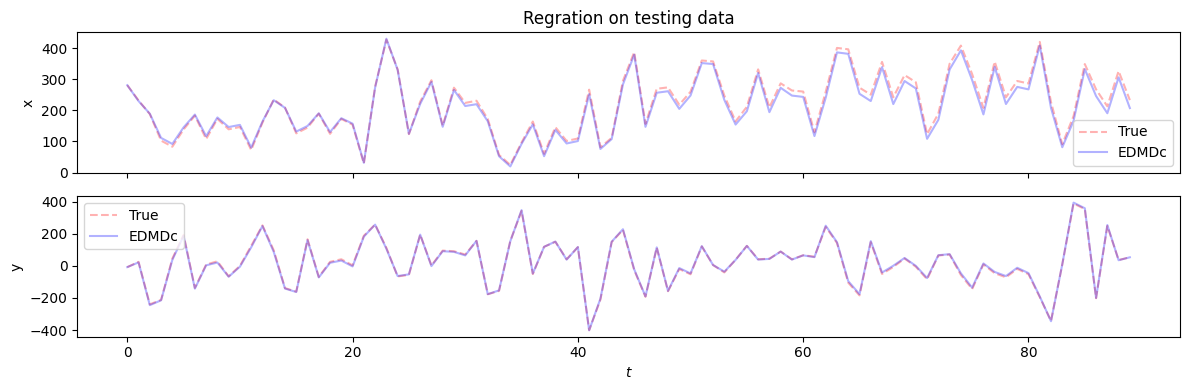

In [50]:
# 绘图
from robot_tools.trajer import TrajInfo

max_train_draw = 90
Xkoop_info = Xtrain_info = TrajInfo.consruct(
    Xtrain,
    "series_h",
    1,
)

trajs_painter = TrajsPainter()
trajs_painter.update_trajs(Xtrain, Xtrain_info)
trajs_painter.features_self_labels = "True"
trajs_painter.features_lines = "--r"
trajs_painter.features_sharetitle = "Regration on testing data"
trajs_painter.features_axis_labels = ["x", "y", "yaw"]
axis = trajs_painter.plot_features_with_t(
    (0, max_train_draw), (0,), (0, 1), return_axis=True
)

trajs_painter.update_trajs(Xkoop, Xkoop_info)
trajs_painter.features_self_labels = "EDMDc"
trajs_painter.features_lines = "-b"
trajs_painter.plot_features_with_t((0, max_train_draw), (0,), (0, 1), given_axis=axis)

In [55]:
err = np.linalg.norm(Xtrain - Xkoop)
print(f"Error: {err:.2f}")

Error: 128.31


# 2D轨迹绘制

## Training

In [ ]:
train_points_num = 15
raw_state_painter = TrajsPainter()
raw_state_painter.update_trajs(Xtrain, Xtrain_info)
raw_state_painter.trajs_labels = "Training trajectories"
axis = raw_state_painter.plot_2D_features((0, train_points_num), (0,), (0, 1), return_axs=True)
raw_state_painter.update_trajs(Xkoop, Xkoop_info)
raw_state_painter.trajs_labels = "Koopman prediction on training trajectories"
raw_state_painter.trajs_lines = "->r"
raw_state_painter.trajs_markersize = 3
raw_state_painter.plot_2D_features((0, train_points_num), (0,), (0, 1), given_axs=axis)

## Testing

In [ ]:
raw_state_painter = TrajsPainter()
raw_state_painter.update_trajs(X_test, X_test_info)
raw_state_painter.trajs_labels = "Testing trajectories"
axis = raw_state_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), return_axs=True)
raw_state_painter.update_trajs(Xk, X_test_info)
raw_state_painter.trajs_labels = "Koopman prediction on testing trajectories"
raw_state_painter.trajs_lines = "->r"
raw_state_painter.trajs_markersize = 3
raw_state_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), given_axs=axis)